<a href="https://colab.research.google.com/github/Voveka98/ml-mipt/blob/master/Lab2_DL_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [0]:
# Your great code here

In [0]:
import torch
from collections import OrderedDict
from torch import nn, optim
import seaborn
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
# Download and load the training data 
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True) 

# Download and load the test data 
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [35]:
trainset.train_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

lol torch.Size([28, 28])


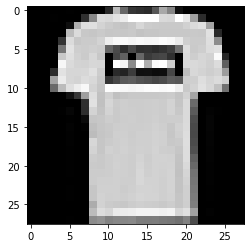

In [36]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(trainset.data[1].reshape((28, 28)), cmap="gray")
print('lol',trainset.data[0].shape)

In [0]:
class Neuro_net(torch.nn.Module):
  def __init__(self):
    super(Neuro_net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=15, kernel_size=5,padding=2)
    #x.shape = 8*28*28
    #после макспула 8*14*14
    # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,padding=1)
    #x.shape = 16*14*14
    #после макспула 16*7*7
    # self.conv3 = nn.Conv2d(in_channels=16, out_channels=36,kernel_size=3, padding=1)
    #x.shape = 36*7*7
    #после макспула 36*3*3
    self.lin1 = nn.Linear(15*14*14,1328)
    self.lin = nn.Linear(1328,768)
    self.lin2 = nn.Linear(768, 384)
    self.lin3 = nn.Linear(384, 128)
    self.lin4 = nn.Linear(128, 80)
    # self.lin5 = nn.Linear(100, 50)
    self.lin6 = nn.Linear(80,10)
    self.act = torch.nn.Tanh()
    self.drop = nn.Dropout(p=0.2)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)),2)
    # x = F.max_pool2d(F.relu(self.conv2(x)),2)
    # x = F.max_pool2d(F.relu(self.conv3(x)),2)
    x = x.view(x.shape[0],-1)
    
    x = self.drop(F.relu(self.lin1(x)))
    x = F.relu(self.lin(x))
    x = F.relu(self.lin2(x))
    x = F.relu(self.lin3(x))
    x = F.relu(self.lin4(x))
    # x = self.act(self.lin5(x))
    x = self.lin6(x)
    return x

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Neuro_net().to(device)

#loss
criterion = torch.nn.modules.CrossEntropyLoss()

#функция оптимизации
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

train_losses = []
test_losses = []

for i in range(num_epochs):
  run_loss = 0
  
  for images,labels in trainloader:
    '''обнуляем градиент, иначе, так как у нас chain rule в вычислении градиента,
    то через пару итераций мы просто забьём всю RAM ненужными цифрами'''
    optimizer.zero_grad()              
    '''подаём изображение на вход сети (forward pass по сути дела)'''
    log_ps = model(images)                     
    '''вычисляем loss'''
    loss = criterion(log_ps, labels)       
    '''backward pass'''
    loss.backward()                            
    optimizer.step()                           
    run_loss += loss.item()                
     
    
  test_loss = 0
  accuracy = 0
    
  # Turn off the gradients
  with torch.no_grad():
    # цикл по валидационному датасету
    for images, labels in testloader:
      log_ps = model(images)                                 
      # ps = torch.exp(log_ps)                                 
      test_loss += criterion(log_ps, labels)             
      top_p, top_class = log_ps.topk(1,dim=1)                    
      equals = top_class == labels.view(*top_class.shape)   
      accuracy += torch.mean(equals.type(torch.FloatTensor))
    
  # записываем средние лоссы на трейне и тесте       
  train_losses.append(run_loss/len(trainloader))
  test_losses.append(test_loss/len(testloader)) 

  #выводим промежуточные результаты
  print("Epoch: {}/{}.. ".format(i+1, num_epochs),
              "Training Loss: {:.3f} ".format(run_loss/len(trainloader)),
              "Test Loss: {:.3f} ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
  

Epoch: 1/50..  Training Loss: 0.783  Test Loss: 0.514  Test Accuracy: 0.810
Epoch: 2/50..  Training Loss: 0.448  Test Loss: 0.424  Test Accuracy: 0.849
Epoch: 3/50..  Training Loss: 0.378  Test Loss: 0.375  Test Accuracy: 0.865
Epoch: 4/50..  Training Loss: 0.335  Test Loss: 0.359  Test Accuracy: 0.872
Epoch: 5/50..  Training Loss: 0.305  Test Loss: 0.331  Test Accuracy: 0.886
Epoch: 6/50..  Training Loss: 0.283  Test Loss: 0.311  Test Accuracy: 0.888
Epoch: 7/50..  Training Loss: 0.264  Test Loss: 0.318  Test Accuracy: 0.885
Epoch: 8/50..  Training Loss: 0.249  Test Loss: 0.309  Test Accuracy: 0.893
Epoch: 9/50..  Training Loss: 0.233  Test Loss: 0.326  Test Accuracy: 0.883
Epoch: 10/50..  Training Loss: 0.220  Test Loss: 0.285  Test Accuracy: 0.898
Epoch: 11/50..  Training Loss: 0.206  Test Loss: 0.275  Test Accuracy: 0.902
Epoch: 12/50..  Training Loss: 0.194  Test Loss: 0.276  Test Accuracy: 0.901
Epoch: 13/50..  Training Loss: 0.182  Test Loss: 0.268  Test Accuracy: 0.906
Epoch: 1